# Loading Libraries and Data

In [ ]:
! pip install contractions
! pip install pyspellchecker
! pip install spacy
! python -m spacy download en_core_web_sm
! pip install tensorflow
! pip install keras
! pip install -q tensorflow seaborn spacy
! pip install imblearn
! pip install tf_keras
! pip install wordcloud

# Other
import os
import pathlib
import kagglehub
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing
import re
import contractions
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
nlp = spacy.load("en_core_web_sm")
from spellchecker import SpellChecker

# Classical Models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)
from imblearn.over_sampling import ADASYN, SMOTE

# Neural Networks
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense,
    Bidirectional, GRU, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#! wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#! unzip glove.6B.zip -d glove6B

import requests, zipfile, io
url = "http://nlp.stanford.edu/data/glove.6B.zip"
r = requests.get(url)
with zipfile.ZipFile(io.BytesIO(r.content)) as zip_ref:
    zip_ref.extractall("glove6B")

# BERT
import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
from datasets import Dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/amazon-kindle-book-review-for-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-kindle-book-review-for-sentiment-analysis


In [ ]:
df = pd.read_csv(f"{path}/all_kindle_review .csv")

# Preprocessing

## Sentiment Mapping

Map sentinment scores into labels. As seen in the histogram beneath there are mostly positive reviews, followed by negative reviews, and neutral reviews being the least common.

In [ ]:
def map_sentiment(rating):
  # Ratings with 1 or 2 will be labeled as negative
  if rating in [1, 2]:
    return 'negative'
  # Ratings with 3 will be labeled as neutral
  elif rating == 3:
    return 'neutral'
  # Ratings with 4 or 5 will be labeles as positive
  elif rating in [4, 5]:
    return 'positive'
  else:
    return None

# Use sentiment instead of rating
df['sentiment'] = df['rating'].apply(map_sentiment)

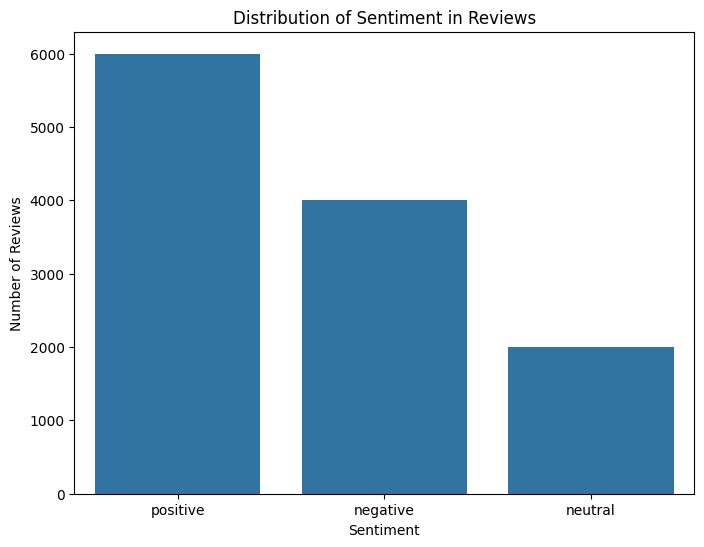

In [ ]:
# Find sentiment distribution
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

# Plot distribution in histogram
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.title('Distribution of Sentiment in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

## Cleaning for Classical Models
Generally classical models perform better with extensive preprocessing. We have therefore decided to lowercase, remove contraction and expansion, correcting spellning errors, apply stopword removal, tokenize, POS tag, lemmatize and handle rare words.

In [ ]:
def classical_clean_basic(text):
  # Lowercasing text
  text = str(text).lower()
  # Handle contractions (don´t --> do not)
  text = contractions.fix(text)
  # Handle expansions (amaaaaaziiing --> amazing)
  text = re.sub(r'(.)\1{2,}', r'\1', text)
  return text

# Apply basic cleaning to reviewText
df['classical'] = df['reviewText'].apply(classical_clean_basic)

Originally, 11% of all words are misspelled. This is bordeline high. Classical models such as Naive Bayes and Logistic Regression handles them poorly. Correcting all spelling errors proved too time-consuming, so we chose to correct only the top 1000 most frequent misspellings instead.

In [ ]:
# Set up spell checker object
spell = SpellChecker()
# Empty list for misspelled words
misspelled_words = []

# Function to count misspellings in a string
def count_misspellings(text):
    words = str(text).split()
    misspelled = spell.unknown(words)
    misspelled_words.extend(misspelled)
    return len(misspelled)

# Adds a new column with count of misspellings in each row
df['misspelled_count'] = df['classical'].apply(count_misspellings)

# Compute overall statistics
total_misspellings = df['misspelled_count'].sum()
total_words = df['classical'].apply(lambda x: len(str(x).split())).sum()
misspelled_percentage = (total_misspellings / total_words) * 100

# Print results
print(f"Total misspelled words: {total_misspellings:,}")
print(f"Misspelled word rate: {misspelled_percentage:.2f}%")

# Build correct dictionary
top_misspellings = dict(Counter(misspelled_words).most_common(1000))
correction_dict = {word: spell.correction(word) for word in top_misspellings if spell.correction(word)}

# Correction function
def correct_text(text):
    return " ".join(correction_dict.get(word, word) for word in str(text).split())

# Apply correction
df['classical'] = df['classical'].apply(correct_text)

Total misspelled words: 158,887
Misspelled word rate: 11.93%


After correcting the top 1000 most frequent spelling errors, the misspelled word rate dropped to just under 7%.

We decided to use **lemmatization over stemming** because:
- lemmatization is more accurate and preserves true word meaning
- handles complex forms accurately
- avoids inccorect cuts
</b>

We decided to include **Part-Of-Speech (POS) tagging**, which assigns grammatical labels to each word. Especially helpfull to improve lemmatization quality and focuses on high-sentiment part os speech.
</b>


In [ ]:
# Loads english language model
nlp = spacy.load("en_core_web_sm")
# Assigns default english stop words from spacy to variable
stop_words = STOP_WORDS

def classical_clean_advanced(text):
  # Parse text into tokens
  doc = nlp(str(text))

  # Filter out punctuation, stopwords, and short tokens
  tokens = [token for token in doc if token.is_alpha and (len(token.text) > 1)]

  # Remove stopwords
  tokens_nostop = [token for token in tokens if token.text not in stop_words]

  # Select meaningful POS - keeps only NOUNs, VERBs, ADJs and ADV
  tokens_nv = [token.text for token in tokens_nostop if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"}]

  # Lemmatize words to base form
  lemmatized = [token.lemma_ for token in tokens_nostop if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"}]

  # Save POS tagging
  pos_tags = [token.pos_ for token in tokens]

  # Adds lemmatized and pos
  return pd.Series([lemmatized, pos_tags], index=["lemmatized", "pos_tags"])

df_cleaned = df.join(df['classical'].apply(classical_clean_advanced))

In [ ]:
# Count lemmatized words
all_words = [word for row in df_cleaned['lemmatized'] for word in row]
word_freq = Counter(all_words)

# Define rare words
rare_words = {word for word, count in word_freq.items() if count <= 3}

# Compute original length
df_cleaned['original_len'] = df_cleaned['lemmatized'].apply(len)

# Removes rare words and updating the 'classical' column
df_cleaned['classical'] = df_cleaned['lemmatized'].apply(
    lambda row: [w for w in row if w not in rare_words])

# Track how many words were removed
df_cleaned['filtered_len'] = df_cleaned['classical'].apply(len)
df_cleaned['count'] = df_cleaned['original_len'] - df_cleaned['filtered_len']

# Print results
print(df_cleaned['count'].describe())

count    12000.000000
mean         1.513167
std          2.961794
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         72.000000
Name: count, dtype: float64


## Cleaning for Neural Networks
As Neural Networks need minimal cleaning. We have tokenized, lowercased and added padding.

In [ ]:
# Tokenize, normalize and lowercase using spaCy pipeline batching
def basic_clean_pipe(docs):
    for doc in docs:
        yield " ".join(tok.lemma_ for tok in doc if tok.is_alpha and not tok.is_stop)

# Fill NAs and convert to lowercase
texts = df['reviewText'].fillna("").str.lower().tolist()

# Apply nlp.pipe with batching
cleaned_texts = list(basic_clean_pipe(nlp.pipe(texts, batch_size=1000)))

# Assign cleaned text back to the DataFrame
df['clean_nn'] = cleaned_texts

In [ ]:
# Fit vocabulary
tok = Tokenizer(oov_token="<UNK>")
tok.fit_on_texts(df['clean_nn'])

# Turn text into integer IDs
seqs = tok.texts_to_sequences(df['clean_nn'])
lengths = np.fromiter((len(s) for s in seqs), dtype=np.int32)
MAX_LEN = int(np.percentile(lengths, 95))

X = pad_sequences(seqs, maxlen=MAX_LEN,
                  padding="post", truncating="post")

## Cleaning for Bert
As BERT performs best without any cleaning. There is not performed any.

In [ ]:
df = df.dropna(subset=['sentiment', 'reviewText'])

## Visualizations
As seen in the visualizations there are some words which are frequently used in book reviews that does not give any valuable insight. </b>

For more advanced NLP/ML algorithms, instead of removing these words, wordembedding is used to capture meaning and relationships. Word embedding methods include GloVe and Word2Vec.

**POS Distribution**
</b>

- Noun-heavy dataset - reviews mention object, topics people and things a lot
- verbs are frequent - reviews express actions, opinions and experiences
- Pronouns and puncutation are common - shows that reviews are written informal and personal
- Adjectives and adverbs are present but smaller - usually carry strong emotional weight and are very valuable for sentiment models

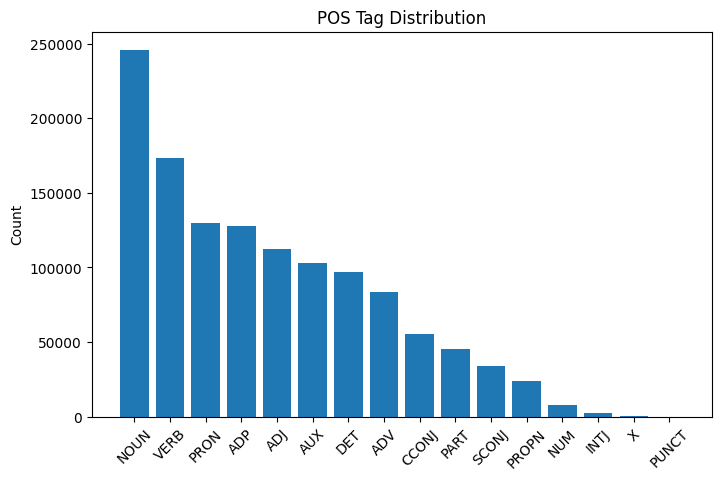

In [ ]:
# Flattens lists to into one big list of tags
all_pos = [pos for tags in df_cleaned['pos_tags'] for pos in tags]
# Counts each POS tag
pos_counts = Counter(all_pos).most_common()

# Visualize in histogram
labels, counts = zip(*pos_counts)
plt.figure(figsize=(8,5))
plt.bar(labels, counts)
plt.title("POS Tag Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

**Most Common Lemmas**
</b>

This shows us that the preprocessing pipeline works. We see words such as "read" instead of "reads" or "reading". Also common stopwords like "the", "was" and "is" are absent. However the dataset has a high frequency of domain-specific words such as "book", "story" and "character". This does not carry sentimen on their own. These should be downeight or excluded when building features.

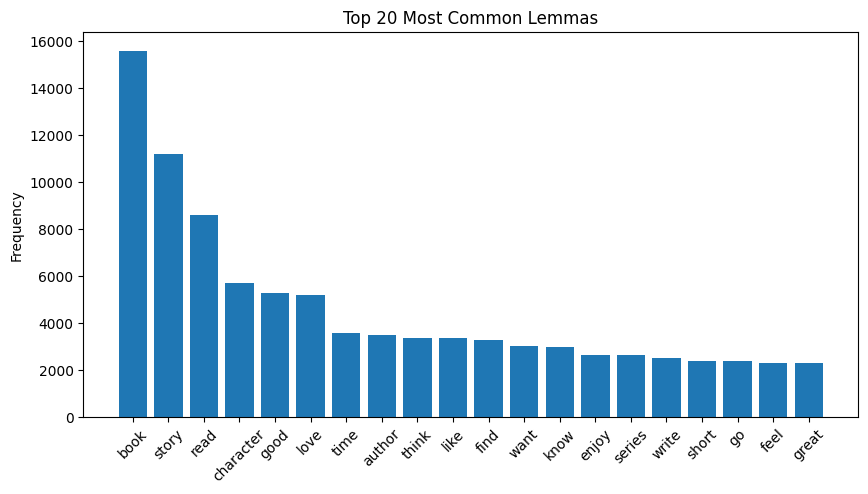

In [ ]:
# Flatten list of all lemmas
all_lemmas = [lemma for lemmas in df_cleaned['lemmatized'] for lemma in lemmas]

# Count top 20
lemma_freq = Counter(all_lemmas).most_common(20)

# Visualize in histogram
words, freqs = zip(*lemma_freq)
plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Lemmas")
plt.ylabel("Frequency")
plt.show()


**Word Clouds Per Sentiment**
</b>

As notet in Most Common Lemmas there are words which are too general for modeling which reduces the value of the illustrations. This is noted for feature selection.

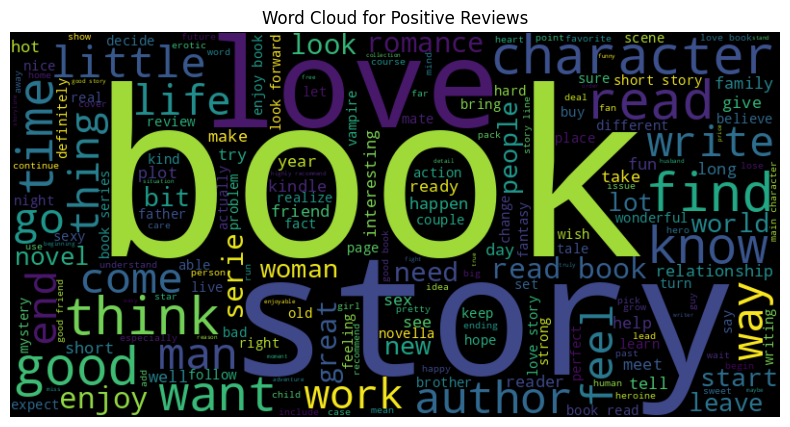

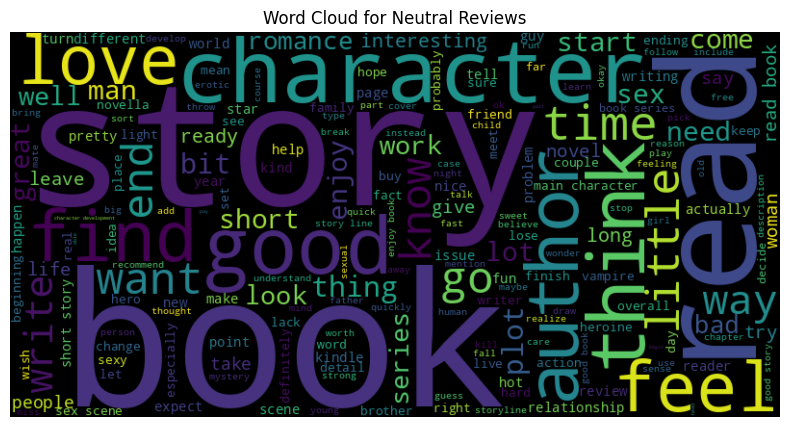

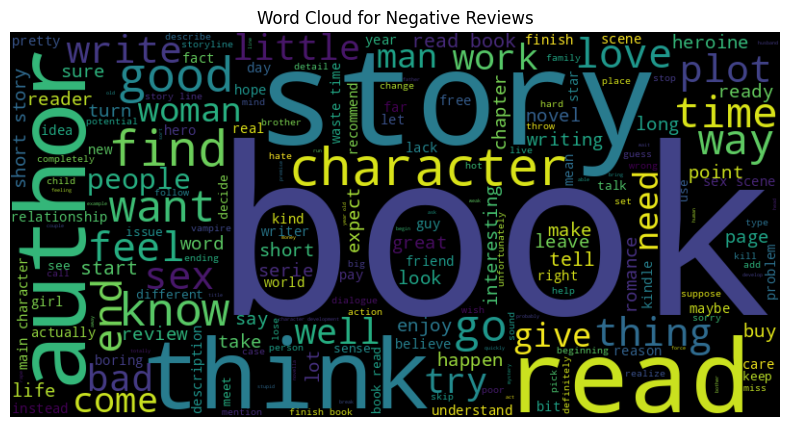

In [ ]:
# Filters rows by sentiment and joins all words into a single string
def get_text_by_sentiment(df, sentiment):
  return " ".join(
      word for word in df[df['sentiment'] == sentiment]['lemmatized'].explode())

# Visualize in word cloud
for sentiment in ['positive', 'neutral', 'negative']:
  text = get_text_by_sentiment(df_cleaned, sentiment)
  wc = WordCloud(width=800, height=400).generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud for {sentiment.capitalize()} Reviews")
  plt.show()

# Train-Test Split

In [ ]:
# Encode sentiment labels to integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['labels'] = df['sentiment'].map(label_map)

# Train test split for NN
X_train, X_val, y_train, y_val = train_test_split(
    X,
    df['labels'].values,
    test_size=0.2,
    stratify=df['labels'].values,
    random_state=42
)

# Train-val split for BERT
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['reviewText'].tolist(),
    df['labels'].tolist(),
    test_size=0.2,
    stratify=df['labels'],
    random_state=42
)

# Classical Models


Minimal Preprocessing [BOW] Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.68      0.81      0.74       800
     neutral       0.42      0.13      0.20       400
    positive       0.78      0.87      0.82      1200

    accuracy                           0.72      2400
   macro avg       0.63      0.60      0.59      2400
weighted avg       0.69      0.72      0.69      2400



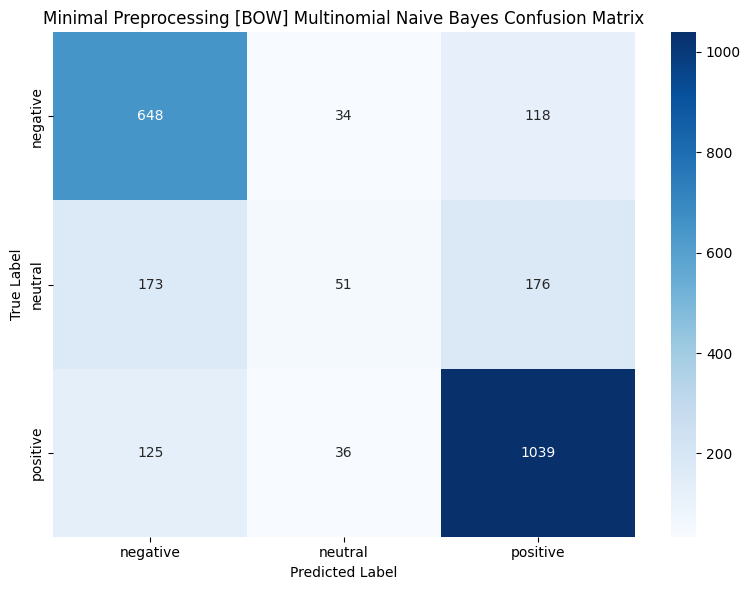


Minimal Preprocessing [BOW] Logistic Regression
              precision    recall  f1-score   support

    negative       0.71      0.72      0.72       800
     neutral       0.35      0.27      0.31       400
    positive       0.77      0.82      0.79      1200

    accuracy                           0.70      2400
   macro avg       0.61      0.60      0.61      2400
weighted avg       0.68      0.70      0.69      2400



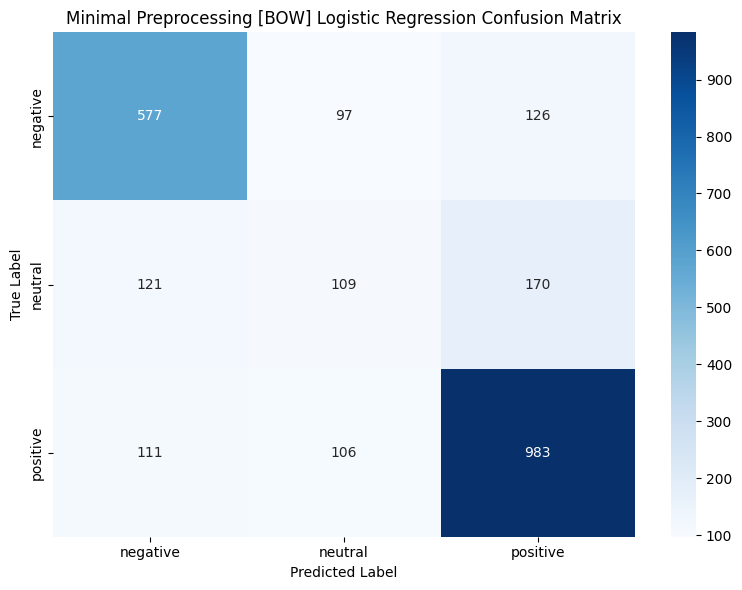


Minimal Preprocessing [TFIDF] Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.85      0.56      0.67       800
     neutral       0.00      0.00      0.00       400
    positive       0.63      0.98      0.77      1200

    accuracy                           0.68      2400
   macro avg       0.49      0.51      0.48      2400
weighted avg       0.60      0.68      0.61      2400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


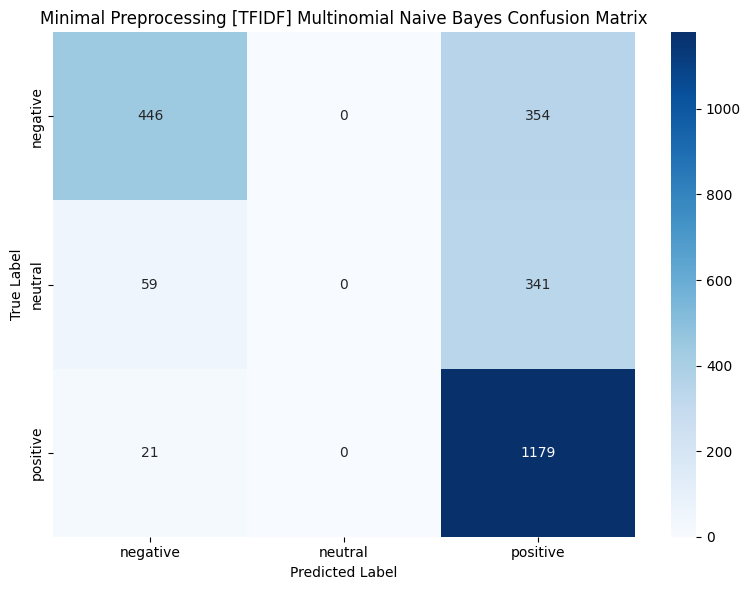


Minimal Preprocessing [TFIDF] Logistic Regression
              precision    recall  f1-score   support

    negative       0.76      0.78      0.77       800
     neutral       0.52      0.18      0.27       400
    positive       0.76      0.90      0.82      1200

    accuracy                           0.74      2400
   macro avg       0.68      0.62      0.62      2400
weighted avg       0.72      0.74      0.71      2400



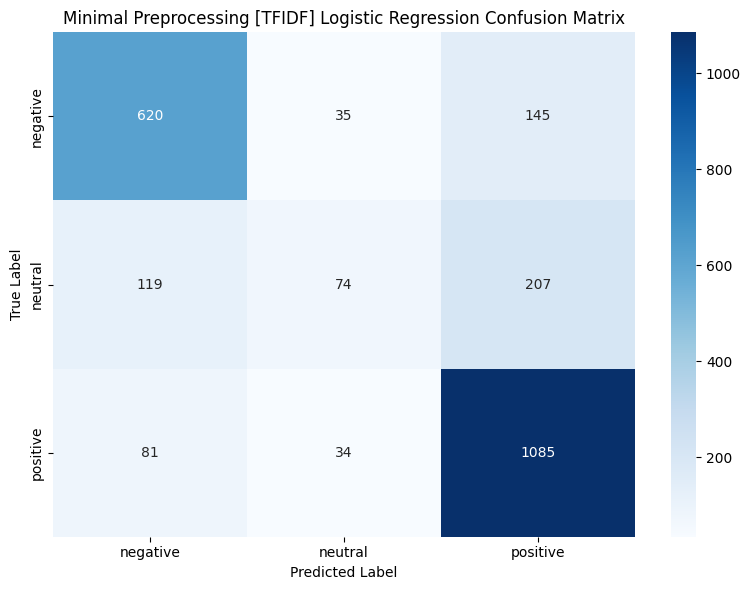


Extensive Preprocessing [BOW] Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.70      0.88      0.78       800
     neutral       0.45      0.15      0.23       400
    positive       0.82      0.85      0.83      1200

    accuracy                           0.75      2400
   macro avg       0.66      0.63      0.61      2400
weighted avg       0.72      0.75      0.71      2400



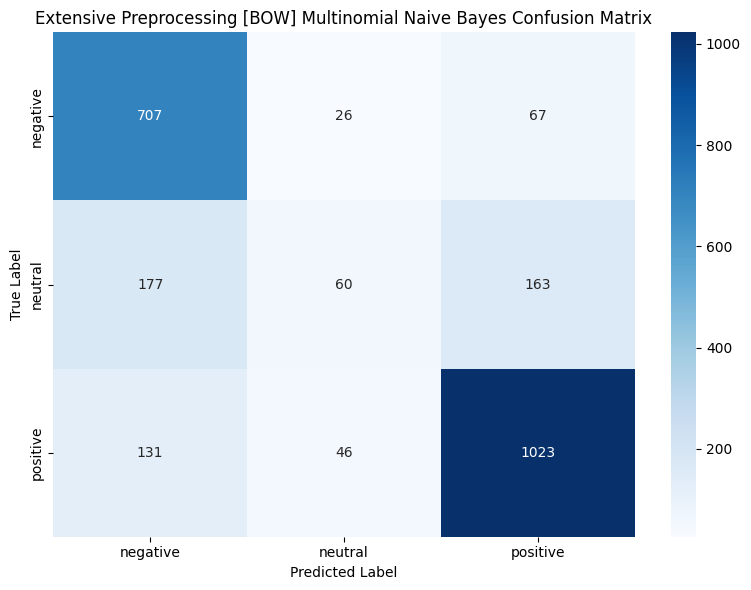


Extensive Preprocessing [BOW] Logistic Regression
              precision    recall  f1-score   support

    negative       0.78      0.76      0.77       800
     neutral       0.36      0.32      0.34       400
    positive       0.80      0.85      0.82      1200

    accuracy                           0.73      2400
   macro avg       0.65      0.64      0.64      2400
weighted avg       0.72      0.73      0.72      2400



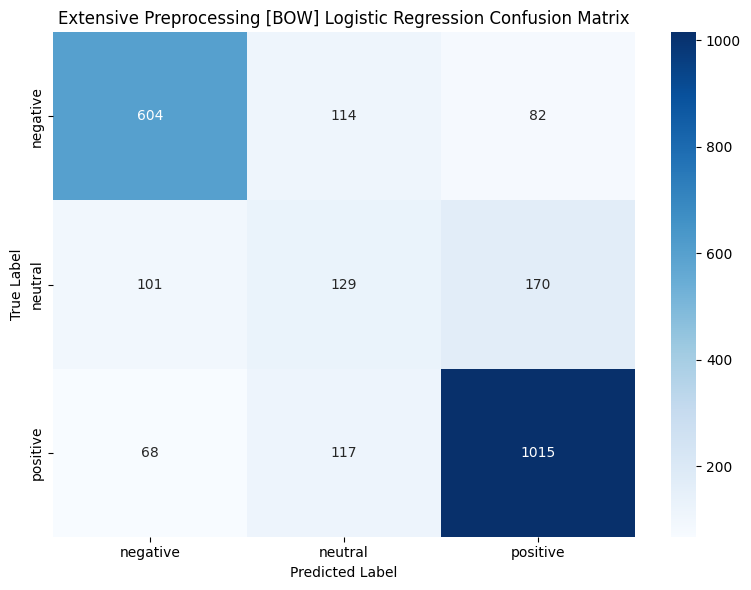


Extensive Preprocessing [TFIDF] Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.90      0.46      0.61       800
     neutral       0.00      0.00      0.00       400
    positive       0.60      0.99      0.75      1200

    accuracy                           0.65      2400
   macro avg       0.50      0.48      0.45      2400
weighted avg       0.60      0.65      0.58      2400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


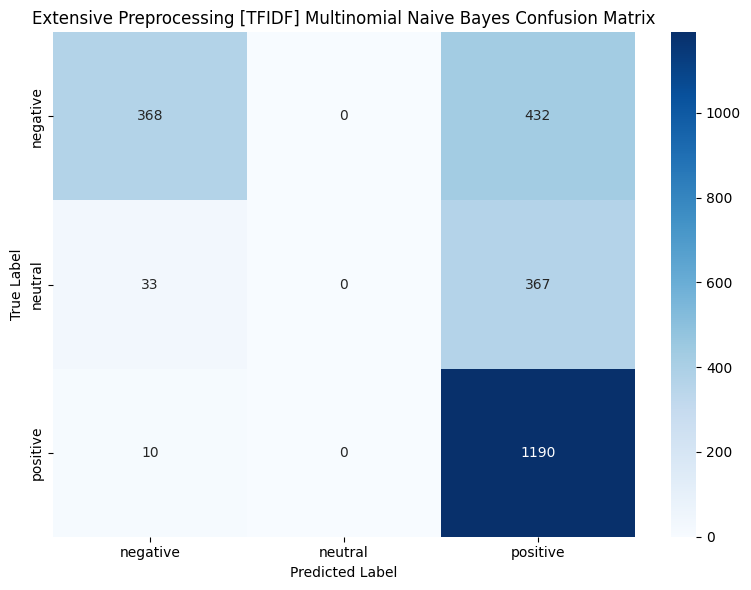


Extensive Preprocessing [TFIDF] Logistic Regression
              precision    recall  f1-score   support

    negative       0.77      0.82      0.80       800
     neutral       0.47      0.18      0.26       400
    positive       0.78      0.91      0.84      1200

    accuracy                           0.76      2400
   macro avg       0.68      0.64      0.63      2400
weighted avg       0.73      0.76      0.73      2400



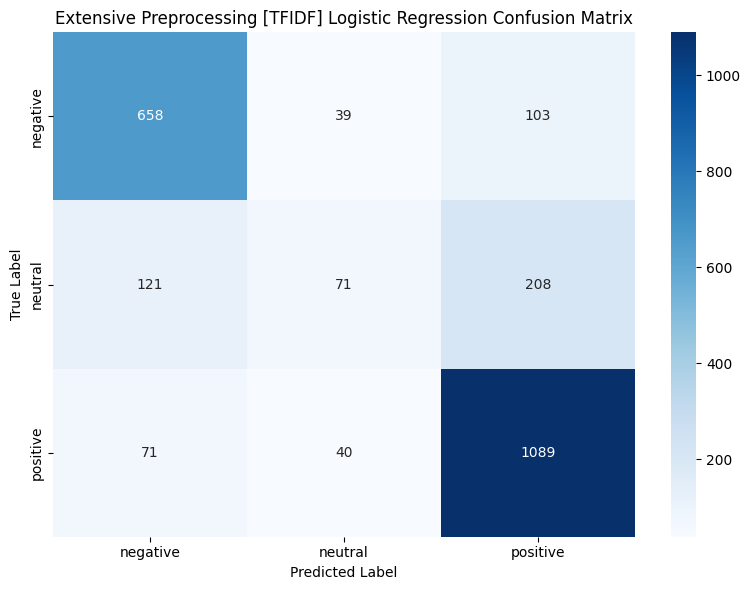


[BoW + ADASYN] Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.72      0.85      0.78       800
     neutral       0.38      0.34      0.36       400
    positive       0.83      0.77      0.80      1200

    accuracy                           0.72      2400
   macro avg       0.64      0.65      0.65      2400
weighted avg       0.72      0.72      0.72      2400



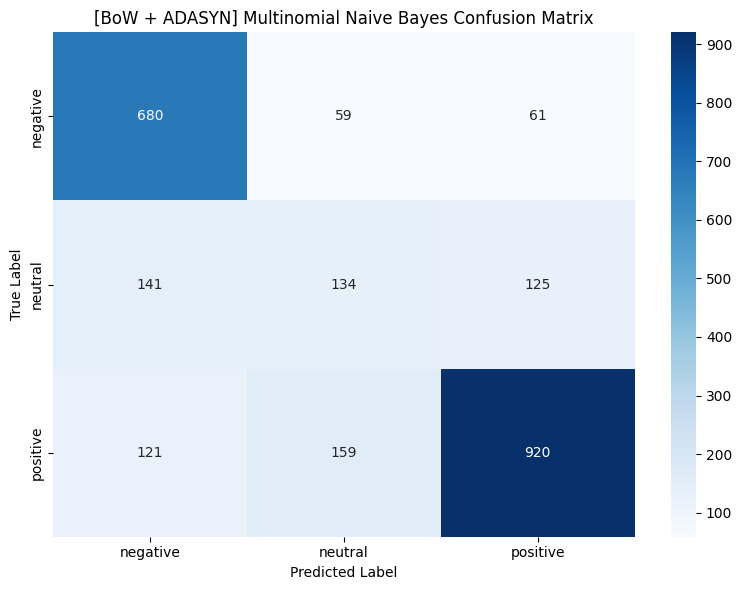


[BoW + ADASYN] Logistic Regression
              precision    recall  f1-score   support

    negative       0.77      0.74      0.75       800
     neutral       0.33      0.37      0.35       400
    positive       0.80      0.79      0.79      1200

    accuracy                           0.70      2400
   macro avg       0.63      0.63      0.63      2400
weighted avg       0.71      0.70      0.70      2400



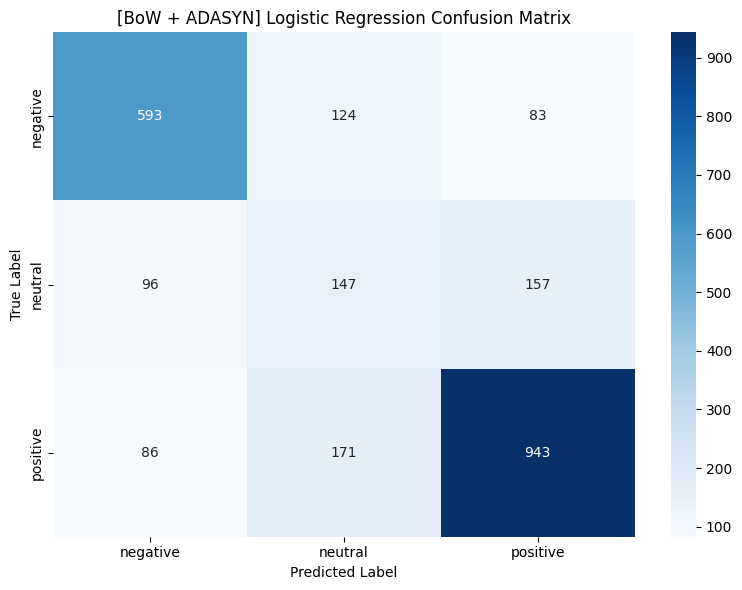


[BoW + SMOTE] Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.74      0.84      0.79       800
     neutral       0.38      0.37      0.38       400
    positive       0.83      0.76      0.80      1200

    accuracy                           0.72      2400
   macro avg       0.65      0.66      0.65      2400
weighted avg       0.73      0.72      0.72      2400



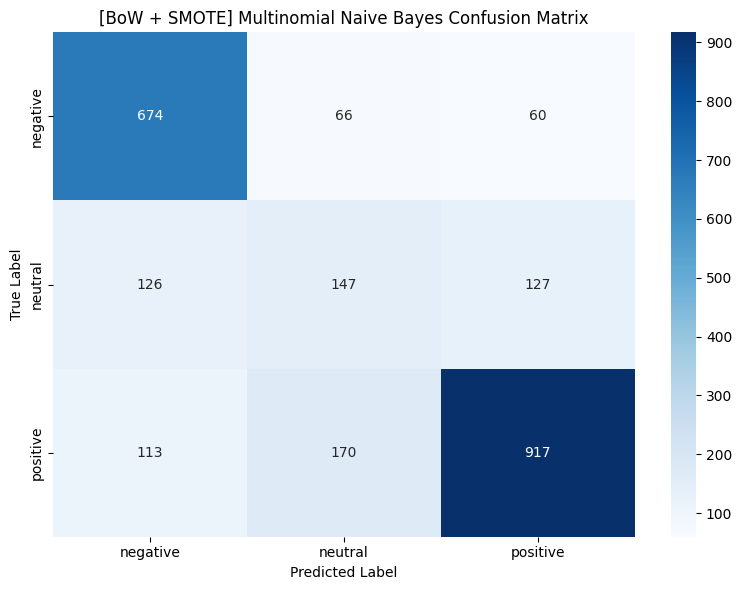


[BoW + SMOTE] Logistic Regression
              precision    recall  f1-score   support

    negative       0.77      0.72      0.75       800
     neutral       0.30      0.35      0.33       400
    positive       0.80      0.78      0.79      1200

    accuracy                           0.69      2400
   macro avg       0.62      0.62      0.62      2400
weighted avg       0.71      0.69      0.70      2400



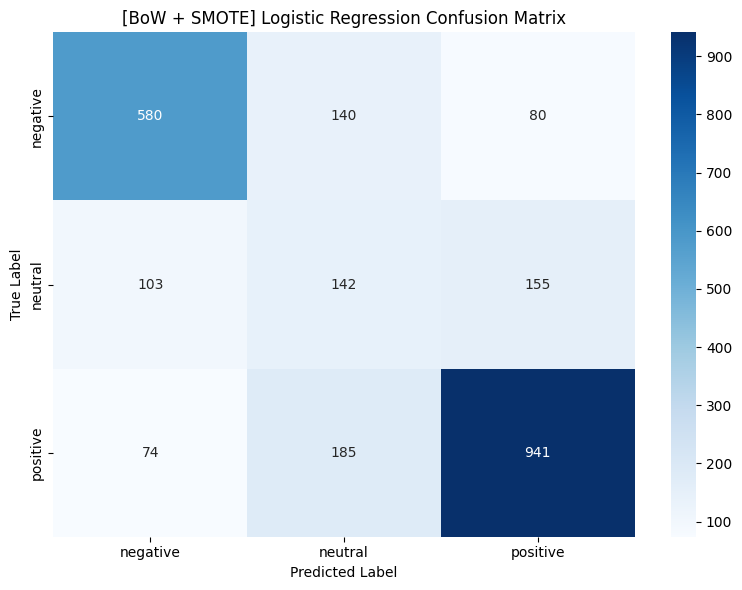

In [ ]:
# Create dictionary for models
models = {
  "Multinomial Naive Bayes": MultinomialNB(),
  "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Vectorization Function to turn text data to numerical feature vectors
def vectorize_data(X_train, X_test, method='bow'):
  vectorizer = CountVectorizer() if method == 'bow' else TfidfVectorizer()
  # Ensure X_train and X_test are lists of strings before vectorizing
  X_train_list = [str(text) for text in X_train]
  X_test_list = [str(text) for text in X_test]
  return vectorizer.fit_transform(X_train_list), vectorizer.transform(X_test_list)

# Model Training and Evaluation Function
def train_and_evaluate(name, model, X_train_vec, X_test_vec, y_train, y_test):
  print(f"\n{name}")
  model.fit(X_train_vec, y_train)
  y_pred = model.predict(X_test_vec)

  # Print results
  print(classification_report(y_test, y_pred, target_names=label_map.keys()))
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()), cbar=True)
  plt.title(f"{name} Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.tight_layout()
  plt.show()

# Function to run experiments with different preprocessing and vectorization methods
def run_experiment(data_df, text_column, preproc_label):
  # Ensure the text column contains string data for vectorization
  X_train_text, X_test_text, y_train, y_test = train_test_split(
      data_df[text_column].astype(str), data_df['labels'],
      test_size=0.2, stratify=data_df['labels'], random_state=42
  )
  for method in ['bow', 'tfidf']:
      X_train_vec, X_test_vec = vectorize_data(X_train_text, X_test_text, method)
      for name, clf in models.items():
          train_and_evaluate(f"{preproc_label} [{method.upper()}] {name}", clf, X_train_vec, X_test_vec, y_train, y_test)

# Function to run experiments with oversampling
def run_oversampling_experiment(data_df, text_column, method='adasyn'):
  # Ensure the text column contains string data for vectorization
  X_train_text, X_test_text, y_train, y_test = train_test_split(
      data_df[text_column].astype(str), data_df['labels'],
      test_size=0.2, stratify=data_df['labels'], random_state=42
  )
  X_train_vect, X_test_vect = vectorize_data(X_train_text, X_test_text)

  sampler = ADASYN(random_state=42) if method == 'adasyn' else SMOTE(random_state=42)
  # Resample the training data only
  X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_vect, y_train)

  for name, clf in models.items():
      train_and_evaluate(f"[BoW + {method.upper()}] {name}", clf, X_train_balanced, X_test_vect, y_train_balanced, y_test)


# Minimal preprocessing (which is effectively the 'classical' column after basic cleaning)
run_experiment(df, "clean_nn", "Minimal Preprocessing")

# Extensive preprocessing (which is the 'classical' column after advanced cleaning and rare word removal)
run_experiment(df, "classical", "Extensive Preprocessing")

# Oversampling: ADASYN
run_oversampling_experiment(df, "classical", method='adasyn')

# Oversampling: SMOTE
run_oversampling_experiment(df, "classical", method='smote')

# Neural Network Models

## GloVe

In [ ]:
# Each word will be represented as a 100-dimensional vector
EMBED_DIM = 100
# File path to GloVe
glove_file = pathlib.Path("glove6B") / f"glove.6B.{EMBED_DIM}d.txt"

# Reads GloVe file and creates dictionary and maps each word to it´s corresponding embedding vector
emb_index = {}
with glove_file.open(encoding="utf-8") as f:
  for line in f:
    word, *vec = line.strip().split()
    emb_index[word] = np.asarray(vec, dtype="float32")

# Map words to their integer indices
vocab_size = len(tok.word_index) + 1
# Initialize embedding with random values
emb_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, EMBED_DIM))

# For each word in the vocabulary it tries to find its pre-trained vector
for word, idx in tok.word_index.items():
  vec = emb_index.get(word)
  if vec is not None:
    emb_matrix[idx] = vec

## CNN

In [ ]:
# Takes input sequens of integers with fixed length
inp_cnn = Input(shape=(MAX_LEN,))

# Converts each word index into its vector representation
emb_cnn = Embedding(vocab_size, EMBED_DIM,
                weights=[emb_matrix],
                input_length=MAX_LEN,
                # Model can fine-tune embeddings during training
                trainable=True)(inp_cnn)

# Apply 1D convolution filters of size 2-6
conv2 = Conv1D(256, 2, activation="relu", padding="same")(emb_cnn)
conv3 = Conv1D(256, 3, activation="relu", padding="same")(emb_cnn)
conv4 = Conv1D(256, 4, activation="relu", padding="same")(emb_cnn)
conv5 = Conv1D(256, 5, activation="relu", padding="same")(emb_cnn)
conv6 = Conv1D(256, 6, activation="relu", padding="same")(emb_cnn)

# Randomly drops 16% of neurons during training to prevent overfitting
conv_stack = concatenate([conv2, conv3, conv4, conv5, conv6])
conv_stack = Dropout(0.16824117756047322)(conv_stack)

# Each convolution´s output is compressed to its most important feature
feat_cnn = concatenate([GlobalMaxPooling1D()(c) for c in (conv2, conv3, conv4, conv5, conv6)])
# Drops 50% of neurons to reduce overfitting before final output layer
feat_cnn = Dropout(0.5)(feat_cnn)
# Output layer with 3 unigs
# Softmax turns a list of numbers into probabilities
out_cnn  = Dense(3, activation="softmax")(feat_cnn)

# Use Adam optimizer with learning rate 0.0016
model_cnn = Model(inp_cnn, out_cnn)
model_cnn.compile(optimizer=Adam(0.0016108321063574083),
  # Used becayse labels are integers
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"])

# Print results
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 151)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 151, 100)  │  2,295,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 151, 256)  │     51,456 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 151, 256)  │     77,056 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 151, 256)  │    102,656 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 151, 256)  │    128,256 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 151, 256)  │    153,856 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_12[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_13[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_14[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1280)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      3,843 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,812,523 (10.73 MB)

 Trainable params: 2,812,523 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

## CRNN

In [ ]:
inp_crnn = Input(shape=(MAX_LEN,))
emb_crnn = Embedding(vocab_size, EMBED_DIM,
                     weights=[emb_matrix],
                     input_length=MAX_LEN,
                     trainable=True)(inp_crnn)

conv2 = Conv1D(160, 2, activation="relu", padding="same")(emb_crnn)
conv3 = Conv1D(160, 3, activation="relu", padding="same")(emb_crnn)
conv4 = Conv1D(160, 4, activation="relu", padding="same")(emb_crnn)
conv5 = Conv1D(160, 5, activation="relu", padding="same")(emb_crnn)
conv6 = Conv1D(160, 6, activation="relu", padding="same")(emb_crnn)

conv_stack = concatenate([conv2, conv3, conv4, conv5, conv6])
conv_stack = Dropout(0.3823929130402751)(conv_stack)

rnn_out = Bidirectional(
    GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)
)(conv_stack)

feat_crnn = Dropout(0.5)(rnn_out)
out_crnn = Dense(3, activation="softmax")(feat_crnn)

model_crnn = Model(inp_crnn, out_crnn)
model_crnn.compile(optimizer=Adam(0.0006816949460296288),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Train

As the dataset is imbalanced class weights is applied to make sure that the model pay attention to underrepresented classes. Neural samples will have the most influence on the luss function, helping the model not to ignore them.

In [ ]:
# Use class weights to handle class imbalance
class_weight = {0: 3.0,   # upping negative
                1: 6.0,   # upping neutral
                2: 2.0}   # positive stays baseline

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=2,
    restore_best_weights=True
)

# Train CNN model
model_cnn.fit(
    # Training data
    X_train, y_train,
    # Validation data
    validation_data=(X_val, y_val),
    # Train up to 10 rounds
    epochs=10,
    # 128 samples a a time
    batch_size=128,
    # Apply class weights
    class_weight=class_weight,
    # Apply early stop
    callbacks=[early_stop]
)

# Train CRNN model, same as CNN
model_crnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[early_stop]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.4353 - loss: 4.5009 - val_accuracy: 0.6129 - val_loss: 0.8337
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6825 - loss: 2.2507 - val_accuracy: 0.6983 - val_loss: 0.7342
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7869 - loss: 1.7070 - val_accuracy: 0.6988 - val_loss: 0.7141
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8725 - loss: 1.1807 - val_accuracy: 0.6483 - val_loss: 0.8316
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9114 - loss: 0.8271 - val_accuracy: 0.7108 - val_loss: 0.7168
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 639ms/step - accuracy: 0.3964 - loss: 3.3645 - val_accuracy: 0.5054 - val_loss: 0.9974
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 633ms/step - accuracy: 0.5472 - loss: 2.9325 - val_accuracy: 0.6012 - val_loss: 0.8740
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 598ms/step - accuracy: 0.6288 - loss: 2.6499 - val_accuracy: 0.5

## Evaluation


Results for CNN
Accuracy : 0.6987
Precision: 0.6193  |  Recall: 0.6239  |  F1: 0.6209

              precision    recall  f1-score   support

    negative       0.71      0.77      0.74       800
     neutral       0.33      0.33      0.33       400
    positive       0.82      0.77      0.80      1200

    accuracy                           0.70      2400
   macro avg       0.62      0.62      0.62      2400
weighted avg       0.70      0.70      0.70      2400



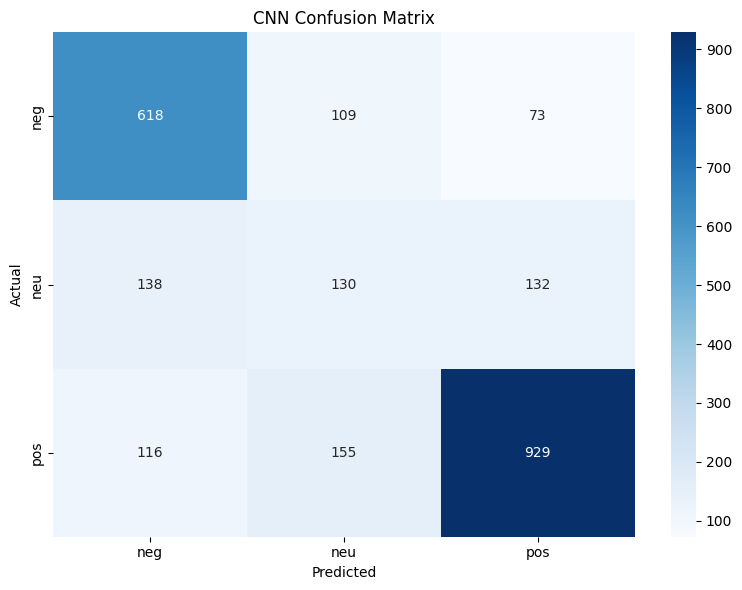


Results for CRNN
Accuracy : 0.6942
Precision: 0.6200  |  Recall: 0.6174  |  F1: 0.6183

              precision    recall  f1-score   support

    negative       0.75      0.71      0.73       800
     neutral       0.31      0.34      0.32       400
    positive       0.80      0.80      0.80      1200

    accuracy                           0.69      2400
   macro avg       0.62      0.62      0.62      2400
weighted avg       0.70      0.69      0.70      2400



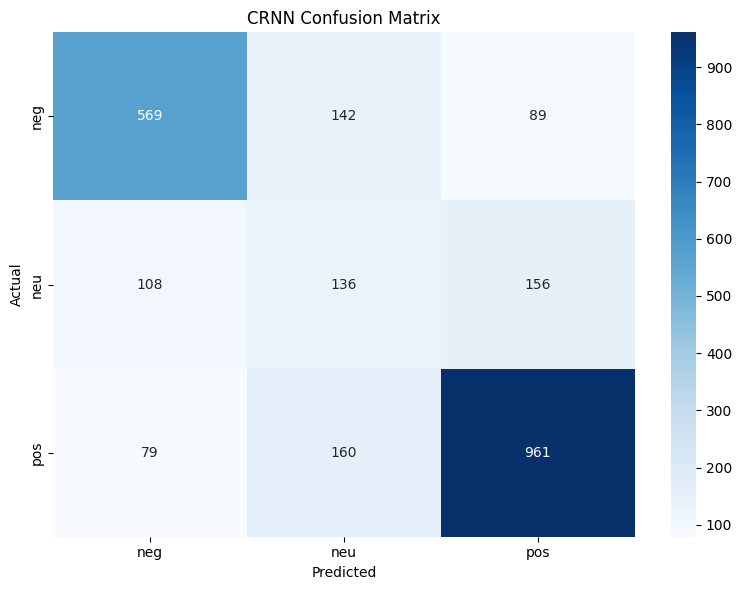

In [ ]:
# Evaluation function
def evaluate_model(model, model_name="Model"):
  # Predict
  y_prob = model.predict(X_val, batch_size=128, verbose=0)
  y_pred = y_prob.argmax(axis=1)

  # Scalar metrics
  acc = accuracy_score(y_val, y_pred)
  prec, rec, f1, _ = precision_recall_fscore_support(
      y_val, y_pred, average="macro", zero_division=0)

  # Print results
  print(f"\nResults for {model_name}")
  print(f"Accuracy : {acc:.4f}")
  print(f"Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")
  print(classification_report(y_val, y_pred,
                                target_names=['negative', 'neutral', 'positive']))

  # Confusion matrix
  cm = confusion_matrix(y_val, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=['neg', 'neu', 'pos'],
              yticklabels=['neg', 'neu', 'pos'])
  plt.title(f"{model_name} Confusion Matrix")
  plt.xlabel("Predicted"); plt.ylabel("Actual")
  plt.tight_layout(); plt.show()

# Evaluate both models
evaluate_model(model_cnn, model_name="CNN")
evaluate_model(model_crnn, model_name="CRNN")

# BERT


## Build

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

In [ ]:
# Create datasets
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

# Training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to='none'
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

Step,Training Loss
500,0.676300
1000,0.454900
1500,0.310800


TrainOutput(global_step=1800, training_loss=0.4385513517591688, metrics={'train_runtime': 2920.622, 'train_samples_per_second': 9.861, 'train_steps_per_second': 0.616, 'total_flos': 7577666430566400.0, 'train_loss': 0.4385513517591688, 'epoch': 3.0})

## Evaluation

Accuracy: 0.8058333333333333

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85       800
     neutral       0.47      0.48      0.48       400
    positive       0.89      0.89      0.89      1200

    accuracy                           0.81      2400
   macro avg       0.74      0.74      0.74      2400
weighted avg       0.81      0.81      0.81      2400



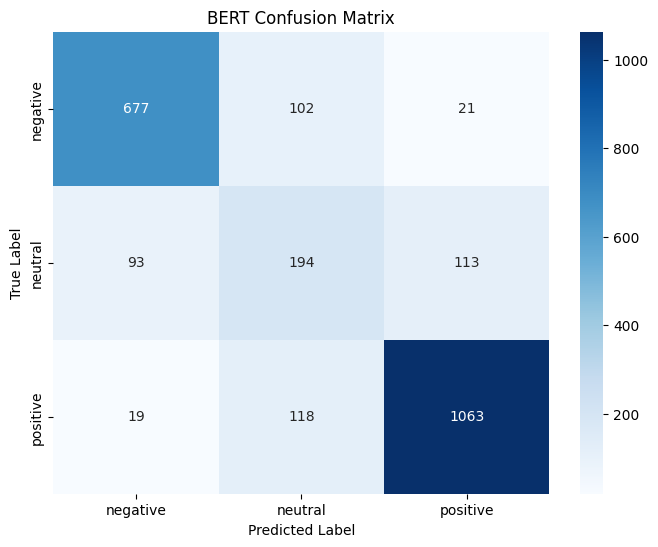

In [ ]:
# Evaluate
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# Results
print("Accuracy:", accuracy_score(val_labels, y_pred))
print("\nClassification Report:")
print(classification_report(val_labels, y_pred, target_names=['negative', 'neutral', 'positive']))

# Confusion matrix
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('BERT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()